In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data

import math

import matplotlib.pyplot as plt
%matplotlib inline

import time


In [11]:
# checking so torch works
A = torch.Tensor(np.array([[1, 2, 3]]))
B = torch.Tensor(np.array([[2, 2, 2]]))
print('torch: ', A.mm(B.t()))



l = [A, B]
print(A)
print(B)
sum(l)



torch:  tensor([[12.]])
tensor([[1., 2., 3.]])
tensor([[2., 2., 2.]])


tensor([[3., 4., 5.]])

## Make a torch model to solve a simple regression problem

In [5]:
class My_model(nn.Module):
    def __init__(self):
        super(My_model, self).__init__()
        # here we design the layers in the network
        #self.l1 = nn.Linear(1, 10)
        # self.l2 = nn.Linear(10,10)
        #self.l3 = nn.Linear(10,1)
        setattr(self, '1', nn.Linear(1, 10))
        setattr(self, '2', nn.Linear(10, 10))
        setattr(self, '3', nn.Linear(10, 1))
        
    def forward(self, x):
        # should be a little more fun then the sequential ones
        x = F.tanh(getattr(self, '1')(x))
        out = F.tanh(getattr(self, '2')(x))
        out = getattr(self, '3')(out+x)
        return out

In [6]:
# kolla på utils dataset och data loader
# require_grad(input)

def trainer(net, epochs, noise, objective='x2'):
    torch.manual_seed(1)    # reproducible

    x = torch.unsqueeze(torch.linspace(-1, 1, 10), dim=1)  # x data (tensor), shape=(100, 1)
    
    if objective == 'x2':
        y = x.pow(2) + noise * torch.rand(x.size())                 # noisy y data (tensor), shape=(100, 1)
    elif objective == 'sinx':
        y = torch.sin(10*x) + noise * torch.rand(x.size())          # noisy y data (tensor), shape=(100, 1)


    # torch can only train on Variable, so convert them to Variable
    x, y = Variable(x), Variable(y)
    # does this help me??
    torch.autograd.set_detect_anomaly(True)

    print(net)  # net architecture

    optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
    loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

    # train the network
    t0 = time.perf_counter()
    
    for t in range(epochs):
        prediction = net(x)     # input x and predict based on x
        loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients

    loss = loss.data.numpy()
    print(time.perf_counter() - t0, "seconds to train")
    
    # view data
    plt.figure(figsize=(10,4))
    plt.scatter(x.data.numpy(), y.data.numpy(), color = "orange")
    plt.plot(x.data.numpy(), prediction.data.numpy(), 'g-', lw=3)

    plt.title('Regression Analysis')
    plt.text(1.0, 0, 'Loss = %.4f' % loss,
                fontdict={'size': 24, 'color':  'red'})
    plt.show()
    
    return loss

My_model(
  (1): Linear(in_features=1, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): Linear(in_features=10, out_features=1, bias=True)
)


/home/samuel/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


2.940139795988216 seconds to train


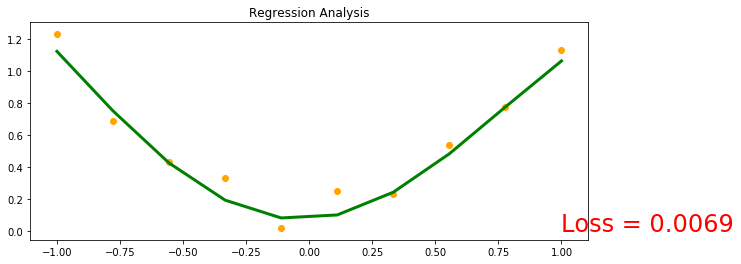

In [7]:
model = My_model()  # define the network
eps = 1000
noise  = 0.3
loss = trainer(model, eps, noise, objective='x2')

## Example of simple model classes


In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

### Testing gamma distributions, I use them to draw skip connections

In [ ]:
# numpy.random.gamma(shape, scale=1.0, size=None)
# (1, 1/2) is probably a good start, maybe more scale later
shape = [1, 2, 2]
scale = [1/2, 1/4, 1/5]
nbr = 10000
for i in range(3):
    data = np.round(np.random.gamma(shape[i], scale=scale[i], size=nbr))
    
    plt.figure()
    plt.hist(data)
    plt.show()

In [ ]:
### IGONERE THIS ###
genome = []
for i in range(4):
    encoding = {
        "active": True,
    }
    if i == 0:
        encoding['skip'] = 8
    elif i == 1:
        encoding['skip'] = 1
    else:
        encoding['skip'] = 0
    genome.append(encoding)

g = {
    "n_nodes": 4,
    "layers": genome,
}

nin = 1
nout = 1

pheno = geno2pheno(g, nin, nout)
print(pheno, '\n')

eps = 500
noise  = 0.3
x = np.ones(nin)
x = torch.Tensor(x)

pheno.forward(x)

loss = trainer(pheno, eps, noise, objective='x2')
